In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plotting import autolabel_bars, latexify, SNS_COLORS

In [2]:
experiments = []
data = {}

**Only execute one cell of the following two.**

In [3]:
DEBUG = True

In [4]:
DEBUG = False
latexify(base_size=10)

# Compression Quality

In [5]:
inet = pd.read_csv("../logs/misc/inet_quality.csv")
p365 = pd.read_csv("../logs/misc/p365_quality.csv")

In [6]:
def plot_quality_hist(data, filename, tight_layout=True, figsize=(9,6.5), legend_loc=None, logy=False):
    fig, ax = plt.subplots(1, 1, figsize=(figsize[0]/2.54, figsize[1]/2.54))

    bins = np.linspace(1, 100, 100)
    _ = ax.hist(data[0], bins=bins, alpha=1, label="ImageNet", zorder=1, color=SNS_COLORS[0], linewidth=0.5)
    _ = ax.hist(data[1], bins=bins, alpha=0.9, label="Places365", zorder=2, color=SNS_COLORS[1], linewidth=0.5)
    
    if legend_loc:
        ax.legend(loc=legend_loc)
    ax.set_xlabel("Compression quality factor")
    ax.set_xlim((1, 100))
    ax.set_xticks([1, 20, 40, 60, 80, 100])
    
    if logy:
        ax.set_yscale("log")
        ax.set_ylabel("Frequency (log)")
    else:
        if tight_layout:
            # tight_layout() must be called to update the offset text
            plt.tight_layout(pad=1.02)
        ax.yaxis.offsetText.set_visible(False)
        ax.set_ylabel(f"Frequency ({ax.yaxis.get_major_formatter().get_offset()})")

    if tight_layout:
        plt.tight_layout(pad=1.02)
    if DEBUG:
        ax.set_title(filename)
        plt.show()
    else:
        plt.savefig(f"../plots/{filename}.pdf", format="pdf", bbox_inches="tight", pad_inches=0.05)
        plt.close()

In [7]:
plot_quality_hist([inet.quality, p365.quality], "misc_quality_hist_lin", figsize=(7.2, 4.5), legend_loc="upper left")
plot_quality_hist([inet.quality, p365.quality], "misc_quality_hist_log", figsize=(7.2, 4.5), logy=True)

# Thrashing

In [8]:
thrashing_exp_paths = glob.glob("../logs/misc/io*")
N_IMAGENET = 1331167  # train and val set

In [9]:
def parse_trashing_report(file):
    data = []
    
    with open(file, "r") as f:
        raw_data = f.readlines()
    
    for line in raw_data:
        parsed_line = json.loads(line[5:-1])
            
        if parsed_line["type"] == "LOG":
            if parsed_line["step"][0] == "E" and "e.total_time" in parsed_line["data"].keys():
                data.append((parsed_line["step"][1] + 1, parsed_line["datetime"], float(parsed_line["data"]["e.total_time"][:-1])))
            elif parsed_line["step"][0] == "P":
                data.append((0, parsed_line["datetime"], 0))
            
    df =  pd.DataFrame(data, columns=["epoch", "end_time", "epoch_duration"])
    df["end_time"] = df.end_time.astype("datetime64[s]")
    df["throughput"] = N_IMAGENET / df["epoch_duration"]
    return df

In [10]:
def parse_iostat(file, epochs):
    with open(file, "r") as f:
        json_data = json.load(f)
        
    df = pd.json_normalize(json_data["sysstat"]["hosts"][0]["statistics"], "disk", ["timestamp", ["avg-cpu", "iowait"]])
    df = df[["timestamp", "disk_device", "tps", "kB_read", "kB_wrtn", "avg-cpu.iowait"]]
    df = df.rename(columns={"avg-cpu.iowait": "cpu_iowait"})
    df = df.astype({"timestamp": "datetime64[s]", "tps": "float64", "kB_read": "float64", "kB_wrtn": "float64", "cpu_iowait": "float64"})
    df["epoch"] = pd.cut(df.timestamp, epochs.end_time, right=True, labels=epochs.epoch[1:])
    return df

In [11]:
def parse_meminfo(file):
    df = pd.read_csv(file, sep="\s+", header=None, index_col=0, usecols=[0, 1], converters={0: lambda x: x[:-1]})
    return df.loc["Cached", 1]

In [12]:
for path in thrashing_exp_paths:
    exp = path.split("/")[-1]
    experiments.append(exp)
    data[exp] = {}
    
    data[exp]["report"] = parse_trashing_report(os.path.join(path, "experiment_report.json"))
    data[exp]["iostat"] = parse_iostat(os.path.join(path, "iostat.json"), data[exp]["report"])
    data[exp]["page_cache_kB"] = parse_meminfo(os.path.join(path, "meminfo.txt"))
    data[exp]["avg_epochtime"] = data[exp]["report"]["epoch_duration"][1:].mean()

In [13]:
def plot_thrashing_comparison(exps, filename, tight_layout=True, figsize=(15,10), legend_loc=None, print_ylabel=False):
    labels = []
    disk_read = []
    cached = []
    
    for exp in exps:
        labels.append(int(exp.split("-")[1][:-1]))
        disk_read.append(data[exp]["iostat"].groupby("epoch").agg({"kB_read": "sum"})["kB_read"][1:].mean() / 1024**2)
        cached.append(data[exp]["page_cache_kB"] / 1024**2 - 1)  # we substract one GiB for files cached by the OS
        
    fig, ax = plt.subplots(1, 1, figsize=(figsize[0]/2.54, figsize[1]/2.54))
    bars = []
    width = 7.5
    
    ax.bar(labels, disk_read, label="Disk IO", width=width, color=SNS_COLORS[0])
    bars += ax.bar(labels, cached, label="Page Cache", bottom=disk_read, width=width, color=SNS_COLORS[1])
    
    ax.axhline(152660528 / 1024**2, color="gray", linestyle="--", alpha=0.8)

    if legend_loc:
        ax.legend(loc=legend_loc, ncol=2)
    ax.set_xlabel("Memory limit")
    ax.set_xticks(ticks=labels)
    if print_ylabel:
        ax.set_ylabel("GiB")
    ax.set_ylim(0, 340)

    autolabel_bars(ax, bars, precision=0, offsets=disk_read)

    if tight_layout:
        plt.tight_layout(pad=1.02)

    if DEBUG:
        plt.show()
    else:
        plt.savefig(f"../plots/{filename}.pdf", format="pdf", bbox_inches="tight", pad_inches=0.05)
        plt.close()

In [14]:
plot_thrashing_comparison([exp for exp in sorted(experiments) if "pytorch" in exp], "misc_trashing_pytorch", figsize=(7.2, 4.5), legend_loc="upper center")
plot_thrashing_comparison([exp for exp in sorted(experiments) if "dali" in exp], "misc_trashing_dali", figsize=(7.2, 4.5))

plot_thrashing_comparison([exp for exp in sorted(experiments) if "pytorch" in exp], "label_gib", figsize=(7.2, 4.5), legend_loc="upper center", print_ylabel=True)

# Average Epoch Times

In [15]:
epoch_time_files = glob.glob("../logs/misc/*alex*/*.json") + glob.glob("../logs/misc/*r18*/*.json") + glob.glob("../logs/misc/*r50*/*.json")

In [16]:
def parse_epoch_time_report(file):
    data = []
    
    with open(file, "r") as f:
        raw_data = f.readlines()
    
    for line in raw_data:
        parsed_line = json.loads(line[5:-1])
            
        if parsed_line["type"] == "LOG" and parsed_line["step"][0] == "E" and "e.total_time" in parsed_line["data"].keys():
            data.append((parsed_line["step"][1] + 1, float(parsed_line["data"]["e.total_time"][:-1])))
            
    df =  pd.DataFrame(data, columns=["epoch", "epoch_duration"])
    return df

In [17]:
for file in epoch_time_files:
    exp = file.split("/")[-2]
    experiments.append(exp)
    data[exp] = {}
    
    data[exp]["report"] = parse_epoch_time_report(file)
    data[exp]["avg_epochtime"] = data[exp]["report"]["epoch_duration"][1:].mean()

In [18]:
for exp in sorted([exp for exp in experiments if "hdd" in exp and "r50" in exp], reverse=True):
    print(f"{exp}    \tavg: {data[exp]['avg_epochtime']:.2f}\tstd: {data[exp]['report']['epoch_duration'][1:].std():.2f}")

inet-r50-raw-hdd-w40    	avg: 6623.00	std: 153.82
inet-r50-jpeg85-hdd-w40    	avg: 2367.19	std: 840.64
inet-r50-jpeg75-hdd-w40    	avg: 1251.41	std: 0.15
inet-r50-jpeg50-hdd-w40    	avg: 1249.98	std: 1.73
inet-r50-jpeg25-hdd-w40    	avg: 1248.39	std: 0.33
inet-r50-jpeg10-hdd-w40    	avg: 1248.12	std: 0.30


In [19]:
for exp in sorted([exp for exp in experiments if "hdd" in exp and "r18" in exp], reverse=True):
    print(f"{exp}    \tavg: {data[exp]['avg_epochtime']:.2f}\tstd: {data[exp]['report']['epoch_duration'][1:].std():.2f}")

inet-r18-raw-hdd-w40    	avg: 6552.41	std: 44.71
inet-r18-jpeg85-hdd-w40    	avg: 2977.61	std: 128.18
inet-r18-jpeg75-hdd-w40    	avg: 451.60	std: 0.31
inet-r18-jpeg50-hdd-w40    	avg: 448.77	std: 0.78
inet-r18-jpeg25-hdd-w40    	avg: 449.31	std: 0.65
inet-r18-jpeg10-hdd-w40    	avg: 447.73	std: 0.50


In [20]:
for exp in sorted([exp for exp in experiments if "hdd" in exp and "alex" in exp], reverse=True):
    print(f"{exp}    \tavg: {data[exp]['avg_epochtime']:.2f}\tstd: {data[exp]['report']['epoch_duration'][1:].std():.2f}")

inet-alex-raw-hdd-w40    	avg: 6580.00	std: 99.10
inet-alex-jpeg85-hdd-w40    	avg: 2406.25	std: 941.45
inet-alex-jpeg75-hdd-w40    	avg: 214.64	std: 0.81
inet-alex-jpeg50-hdd-w40    	avg: 200.19	std: 1.19
inet-alex-jpeg25-hdd-w40    	avg: 192.00	std: 0.29
inet-alex-jpeg10-hdd-w40    	avg: 184.91	std: 0.59


In [21]:
for exp in sorted([exp for exp in experiments if "ssd" in exp], reverse=True):
    print(f"{exp}    \tavg: {data[exp]['avg_epochtime']:.2f}\tstd: {data[exp]['report']['epoch_duration'][1:].std():.2f}")

inet-alex-raw-ssd-w40    	avg: 515.88	std: 2.57
inet-alex-jpeg85-ssd-w40    	avg: 265.22	std: 1.46
inet-alex-jpeg75-ssd-w40    	avg: 214.46	std: 0.64
inet-alex-jpeg50-ssd-w40    	avg: 201.16	std: 0.81
inet-alex-jpeg25-ssd-w40    	avg: 190.10	std: 0.61
inet-alex-jpeg10-ssd-w40    	avg: 185.91	std: 0.68


### Aggregate avg epoch time for 'raw' and 'jpeg-85'

In [22]:
for d in ["raw", "jpeg85"]:
    raw_avg_epochtime = pd.Series(dtype="float64")
    for exp in sorted([exp for exp in experiments if "hdd" in exp and d in exp], reverse=True):
        raw_avg_epochtime = pd.concat([raw_avg_epochtime, data[exp]['report']['epoch_duration'][1:]])

    print(f"{d}\tavg: {raw_avg_epochtime.mean():.2f}\tstd: {raw_avg_epochtime.std():.2f}")

raw	avg: 6585.14	std: 105.08
jpeg85	avg: 2583.68	std: 737.05


# File Sizes

In [23]:
file_sizes = {}
file_sizes["raw"] = pd.read_csv("../logs/misc/inet_raw_filesize.csv")
file_sizes["jpeg75"] = pd.read_csv("../logs/misc/inet_jpeg75_filesize.csv")
file_sizes["jpeg10"] = pd.read_csv("../logs/misc/inet_jpeg10_filesize.csv")

file_sizes["merged"] = pd.merge(file_sizes["raw"], file_sizes["jpeg75"], on="file", suffixes=("_raw", "_jpeg75"))
file_sizes["merged"] = pd.merge(file_sizes["merged"], file_sizes["jpeg10"], on="file")
file_sizes["merged"].columns = ["file", "raw", "jpeg75", "jpeg10"]

array([[<AxesSubplot:title={'center':'raw'}>],
       [<AxesSubplot:title={'center':'jpeg75'}>],
       [<AxesSubplot:title={'center':'jpeg10'}>]], dtype=object)

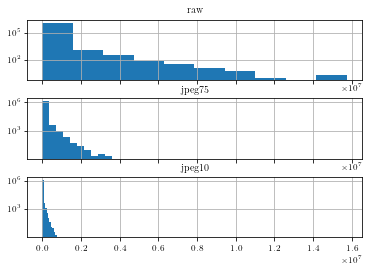

In [24]:
file_sizes["merged"].hist(log=True, sharex=True, layout=(3, 1))

In [25]:
file_sizes["merged"]["raw"].mean() / 1024

112.68675424267649

In [26]:
file_sizes["merged"]["jpeg75"].mean() / 1024

38.390872256466274

In [27]:
file_sizes["merged"]["jpeg10"].mean() / 1024

9.41106081784113